## CSE595 Homework 1 : Logistic Regression Implementation

In [92]:
import pandas
import re
from collections import Counter
import numpy as np
from scipy import sparse
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
%pip install torch
%pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Function to load stop words from NLTK Github Repo to be removed 
def load_stopwords():
    f = open("stopwords.txt")
    words = f.readlines()
    stopwords = set()
    for i in words:
        i = i.strip()
        stopwords.add(i)
    return stopwords

stopwords = load_stopwords()

### Part 1 : Representing Text Data

In [3]:
# tokenizes purely by using whitespace
def tokenize (sentence : str):
    tokens = sentence.split()
    return tokens

In [4]:
# tokenizing by ignoring capitalization, removing stop words as well as all punctuations
def better_tokenize(text : str):
    # store unique tokens in tokens
    tokens = []
    # convert entire text into lowercase
    lowercase = text.lower()
    # find all possible words and all possible punctuations as their own tokens 
    words = re.findall(r"\w+|[,.!?#\r\n$%;:()\"']", lowercase)
 
    for word in words:
        if word not in stopwords:
            tokens.append(word)
    return tokens

In [29]:
# build the vocabulary with a minimum word frequency of 250 along with a column mapping
def build_vocab(token_docs: list):
    vocab, all_tokens = [], []
    vocab_indices = {}
    for doc in token_docs:
        all_tokens.extend(doc)

    # returns frequences of tokens across all documents
    frequencies = Counter(all_tokens)
    
    i = 0
    for freq in frequencies:
    #   if above certain threshold, add to vocab
        if frequencies[freq] >= 250:
            vocab.append(freq)
            vocab_indices[freq] = i
            i += 1
     
    return set(vocab), vocab_indices    

# create term document matrix
def create_sparse_matrix(documents : list):
    tokenized_docs = []
    for doc in documents:
        tokens = better_tokenize(doc)
        tokenized_docs.append(tokens)
    vocab, indices = build_vocab(tokenized_docs)

    dense_matrix = []
    for doc in tokenized_docs:
        row = [0] * len(vocab)
        for token in doc:
            if token in vocab:
                row[indices[token]] += 1
        dense_matrix.append(row)

    np_arr = np.array(dense_matrix)
    sparse_td_matrix = sparse.csr_matrix(np_arr)
    
    return sparse_td_matrix, indices

# create a vector from a singular document of text
def create_document_vector(text, indices):
    tokens = better_tokenize(text)
    row = [0] * len(indices)
    for token in tokens:
        if token in indices:
            row[indices[token]] += 1
    return np.array(row)

# convert boolean dataframe of class labels into numpy array of integers
def create_class_vector(class_labels):
    return np.array(class_labels, dtype=int)


#### Testing Tokenization

In [6]:
df = pandas.read_csv("train.csv")
better_tokenize(df['generation'][0])

['"',
 'conjuring',
 '"',
 'one',
 'thrilling',
 'horror',
 'film',
 'come',
 'recent',
 'times',
 '.',
 '"',
 'sinister',
 '"',
 'one',
 'scariest',
 'films',
 'watched',
 '.',
 'since',
 "'",
 'based',
 '"',
 'true',
 'events',
 '"',
 ',',
 'makes',
 'even',
 'interesting',
 '.',
 "'",
 'quite',
 'give',
 'full',
 '10',
 'star',
 'rating',
 'quite',
 'jump',
 'scares',
 ',',
 'least',
 'good',
 'portion',
 'jump',
 'scares',
 'add',
 'atmosphere',
 'movie',
 '.',
 'first',
 'time',
 'watcher',
 'movie',
 ',',
 'certainly',
 'disturb',
 '.',
 'doesn',
 "'",
 'stick',
 'like',
 '"',
 'sinister',
 '"',
 'long',
 ',',
 'conjuring',
 'fun',
 'watch',
 'always',
 'love',
 'coming',
 'back',
 'rewatch',
 'every',
 '.']

In [23]:
documents_test = ["I like the cat!", "the cat eats.", "i saw this cat and it was adorable i like it so much"]
# matrix, indices = create_sparse_matrix(df["generation"])

print(create_class_vector(df['label'].values))

# print(matrix)
# print(indices)

[0 0 0 ... 1 0 0]


### Part 2 : Logistic Regression w numpy

In [83]:
# Defining sigmoid function that takes in a np array/vector
def sigmoid(x):
    result = 1/(1+np.exp(-x))
    return result

# weights is our beta coefficients, x is the feature vector of a document and y is the ground truth of a document
def log_likelihood(y, predicted_y):
    a = y * predicted_y
    b = np.log(1 + np.exp(predicted_y))
    return a - b

# compute the gradient for a specific x vector, beta coefficients and ground truth y
def compute_gradient(x, y, predicted_y):
    return (sigmoid(predicted_y) - y) * x

In [107]:
# logistic regression with X matrix each row is a feature vector, Y vector, rate of learning and number of steps
def logistic_regression(X, Y, learning_rate, num_step, epochs = 1):

    # Adding a column of ones as bias vector
    bias = np.array([1] * X.shape[0]).reshape(-1, 1)
    sparse_bias = sparse.csr_matrix(bias)
    # horizontally stacking training matrix with bias vector
    X = sparse.hstack([X, sparse_bias], format="csr")

    beta = [0] * X.shape[1]
    # beta values - vector of coefficients initialized to zero
    beta = np.array(beta)
    
    log_likelihoods = []
    for j in range(epochs):
        for i in range(num_step):
            # calculate predicted y using the current coefficient weights
            predicted_y = sparse.csr_matrix.dot(X.getrow(i), beta)
            
            # compute gradient and update beta vector stochastic gradient descent
            beta = np.subtract(beta, learning_rate * compute_gradient(X.getrow(i), Y[i], predicted_y))
            if i  % 20 == 0:
                log_likelihoods.append((i,log_likelihood(Y[i], predicted_y)[0]))
    
    return log_likelihoods

def predict(text, beta, indices):
    test_features = create_document_vector(text, indices)
    predicted_y = np.matmul(test_features, beta)
    return predicted_y


#### Training the Model

In [ ]:
# setting up term document matrix and class labels as a vector
df = pandas.read_csv("train.csv")

# create a sparse matrix for all training documents
matrix, indices = create_sparse_matrix(df["generation"])
Y_class = create_class_vector(df['label'].values)

In [ ]:
# running the training loop for 1000 steps
learning_rate = 5e-5
num_steps = 1000
log_likelihoods = logistic_regression(matrix, Y_class, learning_rate, num_steps)
print(log_likelihoods)

[(0, np.float64(-0.6931471805599453)), (20, np.float64(-0.6773169392478224)), (40, np.float64(-0.8177438170808228)), (60, np.float64(-0.7021307954104485)), (80, np.float64(-0.632505300473943)), (100, np.float64(-0.7317747293802169)), (120, np.float64(-0.7050846820343107)), (140, np.float64(-0.43564808643977637)), (160, np.float64(-0.6741532783887384)), (180, np.float64(-0.6946007209361641)), (200, np.float64(-0.5966837563682894)), (220, np.float64(-0.7284376927820922)), (240, np.float64(-0.5200924324409928)), (260, np.float64(-0.6395226093873041)), (280, np.float64(-0.7831740213757274)), (300, np.float64(-0.6893965464109235)), (320, np.float64(-0.6790708700630522)), (340, np.float64(-0.7004081653228114)), (360, np.float64(-0.7060415192383169)), (380, np.float64(-0.6768205466782236)), (400, np.float64(-0.5945960552982412)), (420, np.float64(-0.23883489761583834)), (440, np.float64(-0.5969086613556492)), (460, np.float64(-0.1654962167222982)), (480, np.float64(-0.08636362079911031)), (50

#### Log likelihood plot for 1000 steps

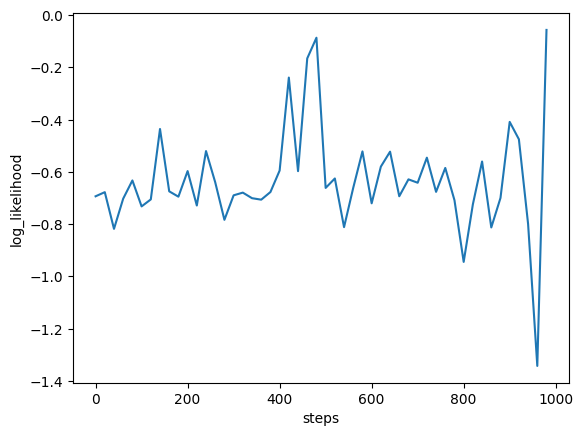

In [103]:
sns.lineplot(data=pandas.DataFrame(log_likelihoods, columns=['steps', 'log_likelihood']), x="steps", y="log_likelihood")
plt.show()

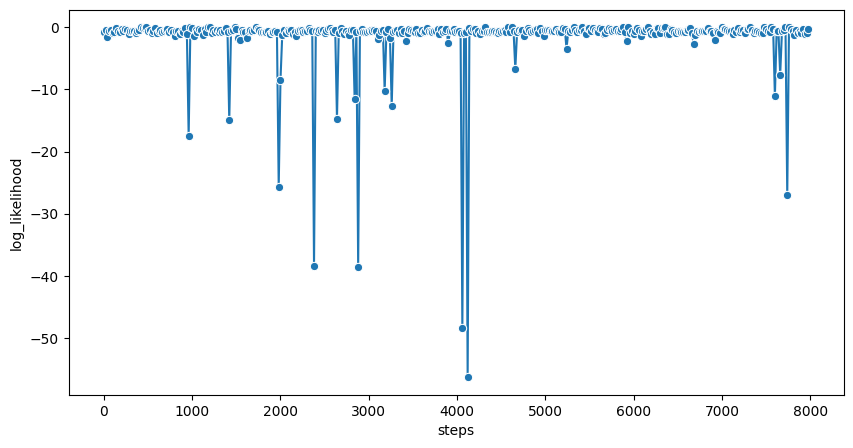

In [129]:
# running the training loop for 1000 steps
learning_rate = 5e-4
num_steps = 8000
log_likelihoods = logistic_regression(matrix, Y_class, learning_rate, num_steps, 1)
# print(log_likelihoods)
plt.figure(figsize=(10, 5)) 

sns.lineplot(data=pandas.DataFrame(log_likelihoods, columns=['steps', 'log_likelihood']), x="steps", y="log_likelihood", marker="o")
plt.show()

### Part 3 : Logistic Regression w Pytorch 

In [107]:
# takes in sparse scipy matrix and converts it into a sparse tensor
def to_sparse_tensor(sparse_scipy):
    # return row and col indices of non zero values along with the values
    row_ind, col_ind, values = sparse.find(sparse_scipy)

    # merge both np arrays to a singular array - this is more efficient - ASK
    indices = np.stack((row_ind, col_ind))
    i = torch.tensor(indices)
    v = torch.tensor(values, dtype=torch.float32)
    return torch.sparse_coo_tensor(i, v)

In [ ]:
# Logistic Regression Class extending nn.Module
class LogisticRegression(nn.Module):
    def __init__(self, vocab_size) -> None:
        # call the base class initialization
        super().__init__()
        # singular output feature for binary classification - is it LLM generated or not?
        # input features would be the size of the vocabulary - how many features should we train on?
        self.linear = nn.Linear(in_features = vocab_size, out_features=1)

    # forward takes in input sparse matrix - documents with all features
    def forward(self, x):
        # pass the linear layer output into sigmoid function and return the probability
        x = nn.Sigmoid(self.linear(x))
        return x
        

In [106]:
documents_test = ["I like the cat!", "the cat eats.", "i saw this cat and it was adorable i like it so much"]
matrix, indices = create_sparse_matrix(documents_test)

print(matrix)
to_sparse_tensor(matrix)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 11 stored elements and shape (3, 8)>
  Coords	Values
  (0, 0)	1
  (0, 1)	1
  (0, 2)	1
  (1, 1)	1
  (1, 3)	1
  (1, 4)	1
  (2, 0)	1
  (2, 1)	1
  (2, 5)	1
  (2, 6)	1
  (2, 7)	1
tensor(indices=tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2],
                       [0, 1, 2, 1, 3, 4, 0, 1, 5, 6, 7]]),
       values=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
       size=(3, 8), nnz=11, layout=torch.sparse_coo)
